[View in Colaboratory](https://colab.research.google.com/github/harvinder-power/sea-eagle-be/blob/master/pneumonia_vs_normal.ipynb)

In [1]:
!pip install kaggle
!apt-get install unzip

    100% |████████████████████████████████| 61kB 2.8MB/s 
    100% |████████████████████████████████| 235kB 6.1MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/2a/21/79/f359bb1659ed86cf1a402bdea9f264f2bcf44489f200882fa0
Successfully built kaggle python-slugify
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [6]:
cd /content

/content


In [10]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving CNN_model2.h5 to CNN_model2.h5
User uploaded file "CNN_model2.h5" with length 22454008 bytes


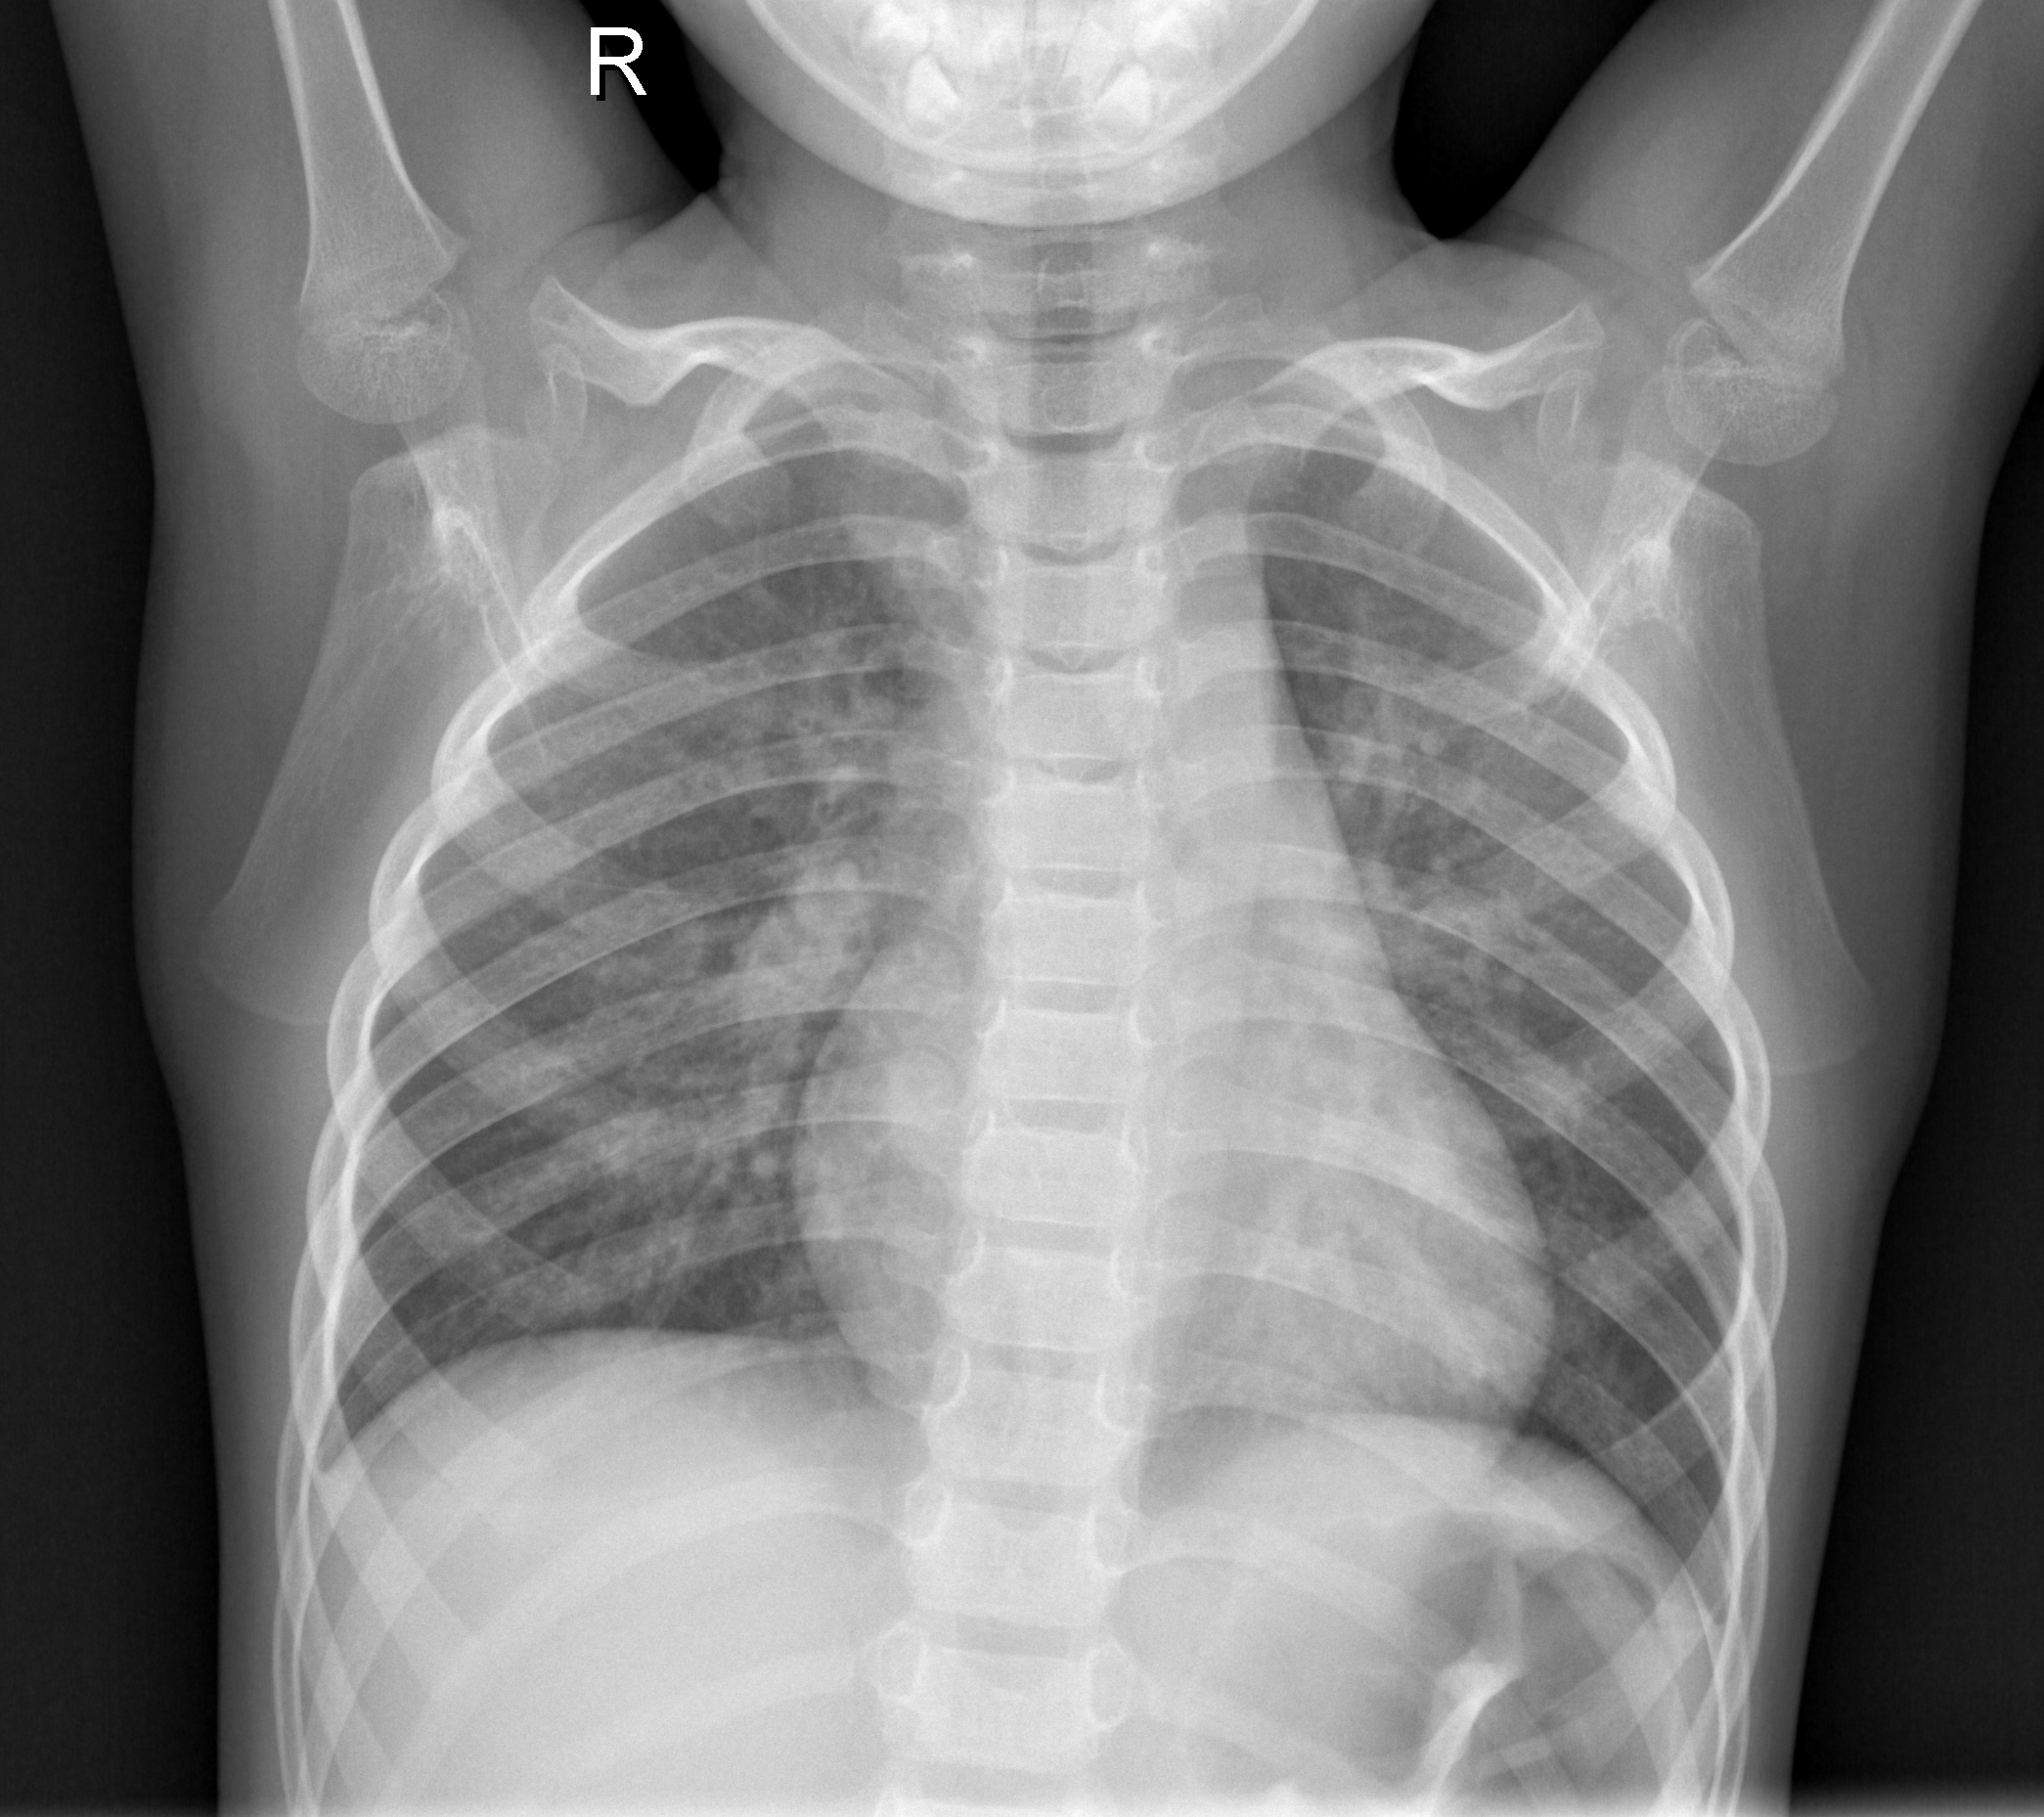

In [49]:
from PIL import Image
Image.open('IM-0115-0001.jpeg')

In [7]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100%|█████████████████████████████████████▉| 1.15G/1.15G [00:15<00:00, 66.3MB/s]
100%|██████████████████████████████████████| 1.15G/1.15G [00:15<00:00, 78.8MB/s]


In [8]:
#unzip -o allows for overwriting
!unzip -o chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          


In [9]:
#%%capture #suppresses output of cell
!unzip -o chest_xray.zip

Archive:  chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person78_bacteria_382.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person124_bacteria_589.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUM

In [12]:
ls

chest_xray/  chest-xray-pneumonia.zip  chest_xray.zip  __MACOSX/  sample_data/


In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99%|█████████████████████████████████████▋| 1.14G/1.15G [00:18<00:00, 61.0MB/s]
100%|██████████████████████████████████████| 1.15G/1.15G [00:18<00:00, 66.3MB/s]


In [10]:
#With added dropouts to reduce risk of over-fitting 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import matplotlib.pyplot as pyplot


# dimensions of our images.
img_width, img_height = 256, 256

train_data_dir = '/content/chest_xray/train'
validation_data_dir = '/content/chest_xray/test'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 25
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)


model.save('CNN_model.h5')
model.save_weights('CNN_weights.h5')

#Epoch 25/25
#125/125 [==============================] - 62s 494ms/step - loss: 0.2293 - acc: 0.9185 - val_loss: 0.3434 - val_acc: 0.8562

Using TensorFlow backend.


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/25
125/125 [==============================] - 65s 523ms/step - loss: 0.6021 - acc: 0.7435 - val_loss: 0.5219 - val_acc: 0.7013
Epoch 2/25
125/125 [==============================] - 62s 495ms/step - loss: 0.4202 - acc: 0.8055 - val_loss: 0.5844 - val_acc: 0.7075
Epoch 3/25
125/125 [==============================] - 61s 486ms/step - loss: 0.3572 - acc: 0.8630 - val_loss: 0.7767 - val_acc: 0.6625
Epoch 4/25
125/125 [==============================] - 59s 471ms/step - loss: 0.3521 - acc: 0.8605 - val_loss: 0.7816 - val_acc: 0.7238
Epoch 5/25
125/125 [==============================] - 58s 467ms/step - loss: 0.3314 - acc: 0.8780 - val_loss: 0.4321 - val_acc: 0.8050
Epoch 6/25
125/125 [==============================] - 60s 484ms/step - loss: 0.3065 - acc: 0.8785 - val_loss: 0.5731 - val_acc: 0.7638
Epoch 7/25
125/125 [==============================] - 62s 496ms/step - loss: 0.2521 - acc: 0.9075 - val_los

In [0]:
model.save('first_try_model.h5')
model.save_weights('first_try_weights.h5')

In [18]:
#With added dropouts to reduce risk of over-fitting
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import matplotlib.pyplot as pyplot


# dimensions of our images.
img_width, img_height = 256, 256

train_data_dir = '/content/chest_xray/train'
validation_data_dir = '/content/chest_xray/test'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 25
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)


model.save('CNN_model2.h5')
model.save_weights('CNN_weights2.h5')

#Epoch 25/25
#125/125 [==============================] - 65s 517ms/step - loss: 0.1838 - acc: 0.9270 - val_loss: 0.3210 - val_acc: 0.8600

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/25
125/125 [==============================] - 69s 556ms/step - loss: 0.5117 - acc: 0.7655 - val_loss: 0.7981 - val_acc: 0.6725
Epoch 2/25
125/125 [==============================] - 64s 509ms/step - loss: 0.3939 - acc: 0.8380 - val_loss: 0.4902 - val_acc: 0.7625
Epoch 3/25
125/125 [==============================] - 63s 506ms/step - loss: 0.2951 - acc: 0.8750 - val_loss: 0.5403 - val_acc: 0.7450
Epoch 4/25
125/125 [==============================] - 63s 507ms/step - loss: 0.2901 - acc: 0.8700 - val_loss: 0.4342 - val_acc: 0.7712
Epoch 5/25
125/125 [==============================] - 64s 515ms/step - loss: 0.2720 - acc: 0.8870 - val_loss: 0.4405 - val_acc: 0.7850
Epoch 6/25
125/125 [==============================] - 64s 508ms/step - loss: 0.2614 - acc: 0.8870 - val_loss: 0.5151 - val_acc: 0.7712
Epoch 7/25
125/125 [==============================] - 63s 507ms/step - loss: 0.2475 - acc: 0.9085 - val_los

In [19]:
ls -lh

total 2.4G
drwxr-xr-x 5 root root 4.0K Mar 22 03:03 chest_xray/
-rw-r--r-- 1 root root 1.2G Aug 30 18:33 chest-xray-pneumonia.zip
-rw-r--r-- 1 root root 1.2G Mar 24 19:42 chest_xray.zip
-rw-r--r-- 1 root root  22M Aug 30 20:46 CNN_model2.h5
-rw-r--r-- 1 root root  15M Aug 30 19:05 CNN_model.h5
-rw-r--r-- 1 root root 7.2M Aug 30 20:46 CNN_weights2.h5
-rw-r--r-- 1 root root 7.2M Aug 30 19:05 CNN_weights.h5
drwxrwxr-x 3 root root 4.0K Mar 22 03:06 __MACOSX/
drwxr-xr-x 2 root root 4.0K Aug 29 17:36 sample_data/


In [11]:
from keras.applications.densenet import DenseNet121
img_width, img_height = 256, 256
model = DenseNet121(include_top=True, weights=None, input_shape=(img_width,img_height,3), classes=2)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import preprocess_input

train_datagen = ImageDataGenerator(
    #rescale=1./255,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True, 
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    '/content/chest_xray/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')
    #color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
    '/content/chest_xray/test',
    target_size=(img_height, img_width),
    batch_size=batch_size, #val_batch_size,
    class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
from keras import optimizers
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True), metrics=['accuracy'])

In [14]:
nb_train_samples = 3036 #300 #8094 #18046 #111589 #113243 #139987 
nb_validation_samples= 336 
epochs = 25 #int(nb_train_samples/batch_size)*3
history = model.fit_generator(
    train_generator,
    steps_per_epoch=batch_size, #nb_train_samples/batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=batch_size, #nb_validation_samples/batch_size, #val_batch_size,
    verbose=1)

pyplot.plot(history.history['acc'])
pyplot.show()

model.save('DNN_model.h5')
model.save_weights('DNN_weights.h5')

Epoch 1/25
32/32 [==============================] - 84s 3s/step - loss: 0.7436 - acc: 0.7607 - val_loss: 5.9803 - val_acc: 0.6290
Epoch 2/25
32/32 [==============================] - 55s 2s/step - loss: 0.3099 - acc: 0.8682 - val_loss: 3.4047 - val_acc: 0.6240
Epoch 3/25
32/32 [==============================] - 55s 2s/step - loss: 0.1933 - acc: 0.9326 - val_loss: 4.1409 - val_acc: 0.6280
Epoch 4/25
32/32 [==============================] - 55s 2s/step - loss: 0.2251 - acc: 0.9258 - val_loss: 4.1946 - val_acc: 0.6230
Epoch 5/25
32/32 [==============================] - 55s 2s/step - loss: 0.1606 - acc: 0.9453 - val_loss: 2.6469 - val_acc: 0.6419
Epoch 6/25
32/32 [==============================] - 55s 2s/step - loss: 0.1431 - acc: 0.9512 - val_loss: 0.6297 - val_acc: 0.8145
Epoch 7/25
32/32 [==============================] - 55s 2s/step - loss: 0.1114 - acc: 0.9629 - val_loss: 0.9075 - val_acc: 0.7589
Epoch 8/25
32/32 [==============================] - 55s 2s/step - loss: 0.1207 - acc: 0.95

KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as pyplot

'/content'

In [21]:
from keras.models import load_model

# Returns a compiled model identical to the previous one
model = load_model('CNN_model2.h5')

Saving normal.jpg to normal.jpg
User uploaded file "normal.jpg" with length 188395 bytes


In [34]:
#NOTE - Unlikely that this assessment of the 

from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(256, 256))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


if __name__ == "__main__":

    # load model
    model = load_model("first_try_model.h5")

    # image path
    img_path = '/content/pneumonia2.jpeg'    # dog
    #img_path = '/media/data/dogscats/test1/19.jpg'      # cat

    # load a single image
    new_image = load_image(img_path)

    # check prediction
    pred = model.predict(new_image)
    print (pred)

[[3.8461607e-05 9.9996150e-01]]


In [28]:
#Prediction for Normal 1
print (pred)

[[1.8934688e-19 1.0000000e+00]]


In [31]:
#Prediction for Normal 2
print (pred)

[[1.8514852e-18 1.0000000e+00]]


In [33]:
#Prediction for Pneumonia 1
print (pred)

[[2.007929e-18 1.000000e+00]]


In [35]:
#Prediction for Pneumonia 2
print (pred)

[[3.8461607e-05 9.9996150e-01]]


In [0]:
#convert model to TF.js - https://medium.com/tensorflow/train-on-google-colab-and-run-on-the-browser-a-case-study-8a45f9b1474e

In [13]:
from keras.models import load_model
model = load_model('CNN_model2.h5')

Using TensorFlow backend.


In [33]:
#NOTE - Unlikely that this assessment of the 

from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(256, 256))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


if __name__ == "__main__":

    # load model
    model = load_model("CNN_model2.h5")

    # image path
    img_path = 'chest_xray/test/PNEUMONIA/person104_bacteria_492.jpeg'    # dog
    #img_path = '/media/data/dogscats/test1/19.jpg'      # cat

    # load a single image
    new_image = load_image(img_path)

    # check prediction
    pred = model.predict(new_image)
    print ('Probability of pneumonia:', pred*100, '%')

Probability of pneumonia: [[99.364235]] %


In [19]:
pwd

'/content'

In [46]:
from keras.models import load_model
from keras.preprocessing import image

img_path = 'chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg'

# load model if already saved
model = load_model("CNN_model2.h5")

#Convert image to an array
img = image.load_img(img_path, target_size=(256,256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
new_image = img_array/255. #Must normalise numbers to a scale of 0-1

prediction = model.predict(new_image)
print ('Probabiliy of pneumonia', prediction*100, '%')


Probabiliy of pneumonia [[95.4706]] %


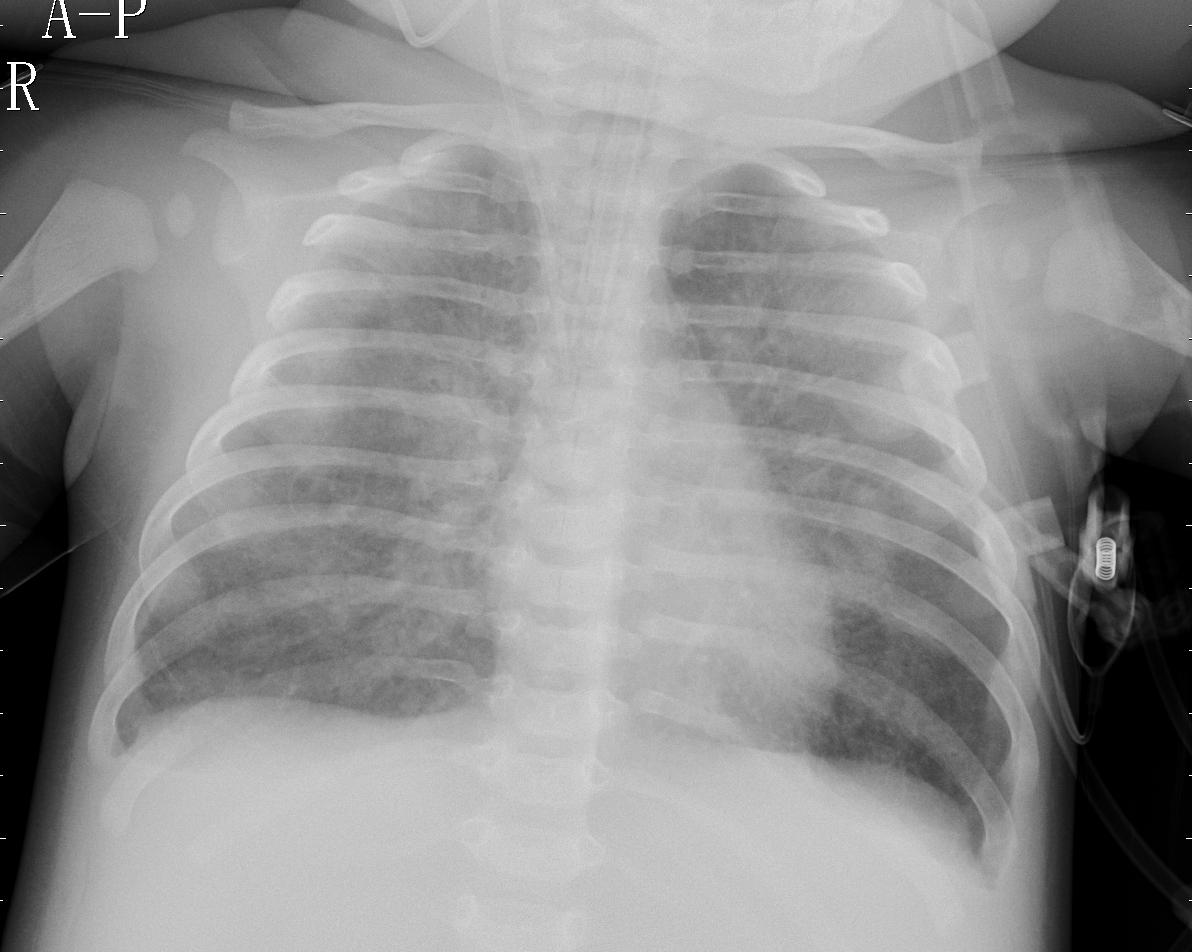

In [45]:
from PIL import Image
Image.open('chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg')